# EDA Schuhgröße

Dieses Notebook: Erste Schritte für eine explorative Datenanalyse zum Datensatz "Schuhgröße", WS 2022.

## Busines Case

Ursprünglich Busines Case 3 in <http://jbusse.de/2021_ws_dsci/dsci-101-statur.html#statur-bc1> , im WS 2022 aber ohne die Spalte "Gewicht".

Vorherzusagen (Target) ist die Spalte Gender. Wir nehmen an, dass in einer Konsumenten-Analyse das Attribut "Gender" nicht erhoben wird, wir aber genau daran sehr interessiert sind. Also erschließen wir Gender aus Körpergröße und Schuhgröße.

## Datensatz beschreiben

Hier etwas nachforschen: Was wissen wir über die Herkunft der Daten? Die beschriebene Domäne, hier: die Menschen? Warum wurden die Daten erhoben, wofür sind sie (nicht) repräsentativ? etc.

Auch schon hier Erebnisse aus der nachfolgenden Analyse "spoilern"? Ja, denn CRISP-DM ist ein iterativer Prozess, und unser Notebook ist das Ergebnis dieses iterativen Prozesses.

## Daten und Bibliotheken einlesen

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown, Latex

In [2]:
random_state=42

Erwachsen_Alter = 15 # Faustregel, Klischee, gesellschaftliche Konstruktion: muss man sicherlich noch diskutieren!

## Datensatz als Aufgabe herstellen

In [3]:
dbsrc = {} # database, source version

In [4]:
#X = pd.read_csv("../data/schuhgroesse_ws2021.csv", delimiter=',')
X = pd.read_csv("../data/schuhgroesse_ws2022.csv", delimiter=',')
print(X.columns)
y = X.pop("Gender")
X.describe()

Index(['Alter', 'Körpergröße', 'Schuhgröße', 'Gender'], dtype='object')


Alter  Körpergröße  Schuhgröße
count  310.000000   311.000000  345.000000
mean    28.287097   139.551029   45.017391
std     18.157122    64.626959   18.919190
min      1.000000     1.000000    0.000000
25%     18.000000   123.000000   38.000000
50%     23.000000   170.000000   41.000000
75%     33.000000   180.000000   44.000000
max     85.000000   260.000000   99.000000

In [5]:
X.head()

Alter  Körpergröße  Schuhgröße
0   11.0        120.0        99.0
1    4.0        108.0        99.0
2    3.0          NaN        99.0
3    6.0          NaN        99.0
4   16.0        175.0        44.0

<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

dbsrc["train"] = X_train
dbsrc["train"]["Gender"] = y_train  # y-Spalte wieder hinzufügen

dbsrc["test"]  = X_test
dbsrc["test"]["Gender"] = y_test

In [7]:
#for z in dbsrc:
#    display(dbsrc[z].describe())

In [8]:
for z in dbsrc:
    print(f"writing file {z}.csv")
    dbsrc[z].to_csv(f"statur_{z}.csv", sep=';', index = False)

writing file train.csv
writing file test.csv


## Datensatz analysieren

Um uns Arbeit zu ersparen, legen wir den Original- und alle Teil-Datensätze nicht als eigene Variablen, sondern als in dict von DataFrames an.

In [9]:
database = {} # Alle Dataframes, mit denen wir rechnen

In [10]:
database["train"] = pd.read_csv("statur_train.csv", delimiter=';')
database["train"].columns

Index(['Alter', 'Körpergröße', 'Schuhgröße', 'Gender'], dtype='object')

In [11]:
assert set(database["train"].columns) == {'Körpergröße', 'Alter', 'Schuhgröße', 'Gender' }

## EDA incl. Cleaning

In [12]:
database["train"].head(3)

Alter  Körpergröße  Schuhgröße Gender
0   13.0        155.0        36.5      b
1   19.0        175.0        42.0      b
2   33.0        181.0        44.0  m(an)

### Cleaning

In [13]:
database["train_clean"] = database["train"].copy() # Eine Kopie erzwingen
X = database["train_clean"] # ein Pointer, keine Kopie: Änerungen auf X ändern auch "database['train_clean']"

Die Gender-Spalte hat fehlerhafte Einträge:

In [14]:
set(database["train_clean"]["Gender"])

{'b',
 'b(oy)',
 'd',
 'f',
 'f\n',
 'g',
 'g(irl)',
 'm',
 'm\n',
 'm(an)',
 nan,
 'w',
 'w(oman)'}

In [15]:
def fn_clean_gender(string):
    if string in [ None, np.nan, "" ]:
        return "NaN"
    else:
        return string[0].lower()

In [16]:
fn_clean_gender("")
database["train_clean"]["Gender"] = database["train_clean"]["Gender"].apply(lambda x: fn_clean_gender(x))
set(database["train_clean"]["Gender"])

{'NaN', 'b', 'd', 'f', 'g', 'm', 'w'}

### Einheit für  Körpergröße 

Das funktioniert:
```
X.Körpergröße[X.Körpergröße > 3] = X.Körpergröße/ 100 
```

Aber es kommt eine Warnung:

> SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
>
> See the caveats in the documentation: <https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy>

Besser: "The following is the recommended access method using `.loc` for multiple items (using `mask`) "

In [17]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
mask = X.Körpergröße == 999
X.loc[mask, 'Körpergröße'] = np.nan 

mask = X.Körpergröße < 30 # kleiner als 30 cm ist niemand, also ist die Größe in m angegeben: in cm umrechnen
X.loc[mask, 'Körpergröße'] = X.loc[mask, 'Körpergröße'] * 100 

In [18]:
mask = X.Alter > 120
X.loc[mask, 'Alter'] = np.nan 

In [19]:
mask = X.Schuhgröße == 99
X.loc[mask, 'Schuhgröße'] = np.nan 

In [20]:
max(X.Alter)

84.0

## Datensatz visualisieren

JB: Einige Routine-Schritte sind schon gegeben, kann man aber bei Bedarf ergänzen.

In [21]:
# Sorge für Konsistenz in der Farbgebung von Seaborn:
# Seaborne Farben dem Geschlecht eindeutig zuweisen
markers={"Gender": ["^", "^", "^",  "o",  "o",  ".",  "."]}
palette={"Gender": {
    "f": "r", 
    "g":"r",
    "w": "r",
    "m": "b", 
    "b": "b",
    "d": "y",
    "NaN": "y",
    "n": "y"
    }}
hue="Gender"

Eine Vorschau auf eine lineare Regression (JB: Welche Regression verwendet Seaborne hier eigentlich?) 
 zeigt, dass das entstehende Modell suboptimal ausfallen wird, wenn man nicht nach Geschlecht oder heranwachsend/erwachsen differenziert:

<AxesSubplot: xlabel='Alter', ylabel='Schuhgröße'>

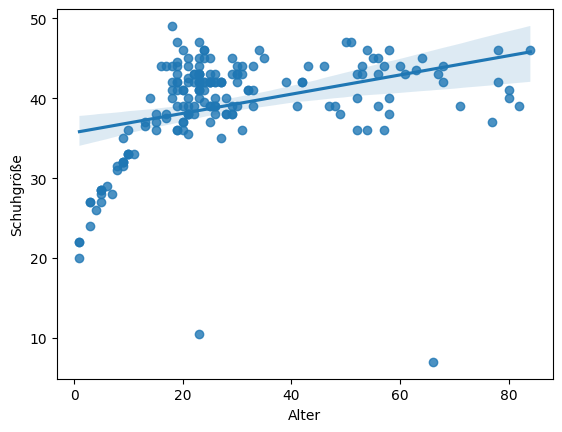

In [22]:
sns.regplot(x="Alter", y="Schuhgröße", data=database["train_clean"])

Wir wollen also im Folgenden mit verschiedenen Teil-Datensätzen weiterarbeiten.

In [23]:
database["Erwachsen"] = database["train_clean"].copy().loc[database["train_clean"].Alter > Erwachsen_Alter]
database["Heranwachsend"] = database["train_clean"].copy().loc[database["train_clean"].Alter <= Erwachsen_Alter]
database["Frauen"] = database["train_clean"].loc[(database["train_clean"].Alter > Erwachsen_Alter) & (database["train_clean"].Gender=='f')]
database["Maenner"] = database["train_clean"].loc[(database["train_clean"].Alter > Erwachsen_Alter) & (database["train_clean"].Gender=='m')]

In [24]:
# alle Original- und Teildatensätze, für die wir die Auswertung machen wollen
focus = ["train_clean", "Heranwachsend", "Erwachsen", "Frauen", "Maenner"]

In [25]:
for f in focus:
    display(Markdown(f'**{f}**'))
    display(database[f].describe())

**train_clean**

Alter  Körpergröße  Schuhgröße
count  206.000000   206.000000  204.000000
mean    28.645631   166.446602   39.085784
std     18.555011    26.079701    6.626469
min      1.000000    81.000000    1.000000
25%     18.250000   162.250000   37.000000
50%     23.000000   173.000000   41.000000
75%     33.000000   181.000000   43.000000
max     84.000000   260.000000   49.000000

**Heranwachsend**

Alter  Körpergröße  Schuhgröße
count  40.000000     31.00000   32.000000
mean    7.900000    120.83871   30.718750
std     4.584254     22.79634    4.954531
min     1.000000     81.00000   20.000000
25%     4.000000    105.00000   27.750000
50%     8.500000    120.00000   31.500000
75%    11.000000    137.00000   33.500000
max    15.000000    162.00000   40.000000

**Erwachsen**

Alter  Körpergröße  Schuhgröße
count  166.000000   151.000000  149.000000
mean    33.644578   174.536424   41.077181
std     17.126274    14.509663    4.788685
min     16.000000   100.000000    7.000000
25%     22.000000   168.500000   39.000000
50%     26.000000   175.000000   42.000000
75%     45.250000   182.000000   44.000000
max     84.000000   201.000000   49.000000

**Frauen**

Alter  Körpergröße  Schuhgröße
count  21.000000    20.000000   20.000000
mean   31.095238   168.800000   39.475000
std    12.099193     7.619918    1.464267
min    20.000000   155.000000   36.000000
25%    23.000000   163.750000   38.750000
50%    26.000000   167.500000   39.250000
75%    33.000000   173.250000   41.000000
max    58.000000   184.000000   42.000000

**Maenner**

Alter  Körpergröße  Schuhgröße
count  87.000000    80.000000   79.000000
mean   37.402299   181.437500   43.139241
std    18.523059     8.171955    4.162513
min    17.000000   165.000000   10.500000
25%    23.000000   175.000000   42.000000
50%    30.000000   181.000000   43.000000
75%    52.500000   185.000000   45.000000
max    84.000000   201.000000   49.000000

**train_clean**

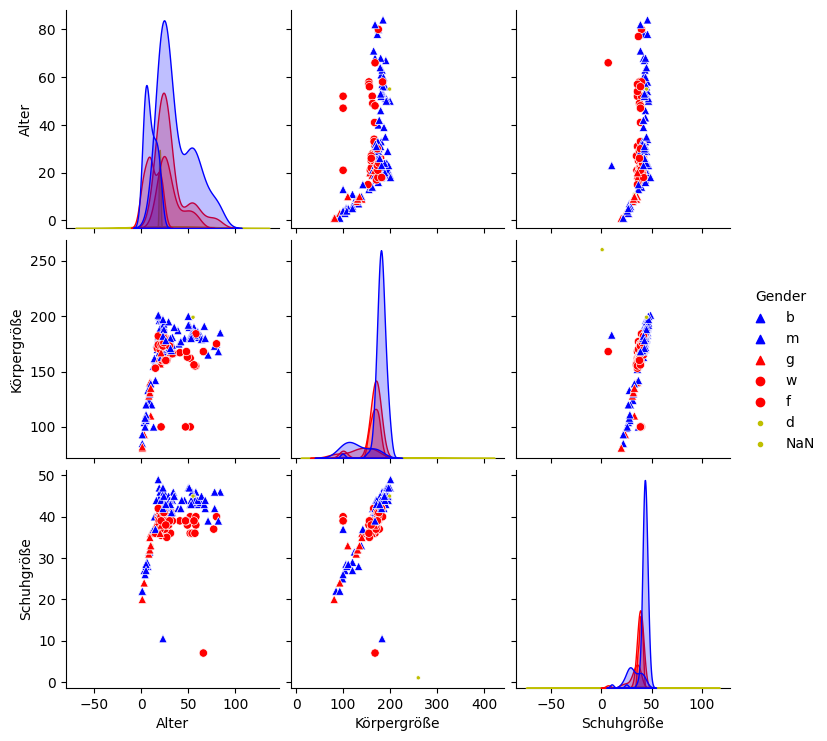

In [26]:
f="train_clean"
display(Markdown(f"**{f}**"))
sns.pairplot(database[f], hue=hue, 
             markers=markers[hue], palette=palette[hue]
            )

**Heranwachsend**

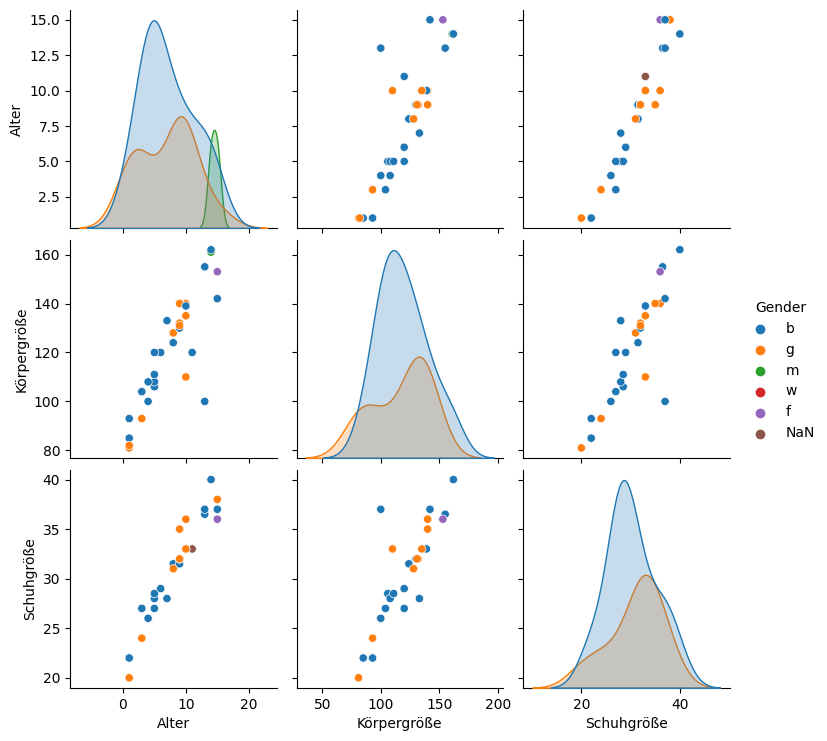

In [27]:
f="Heranwachsend"
display(Markdown(f"**{f}**"))
sns.pairplot(database[f], hue=hue, 
             # markers=markers[hue], palette=palette[hue]
            )

**Erwachsen**

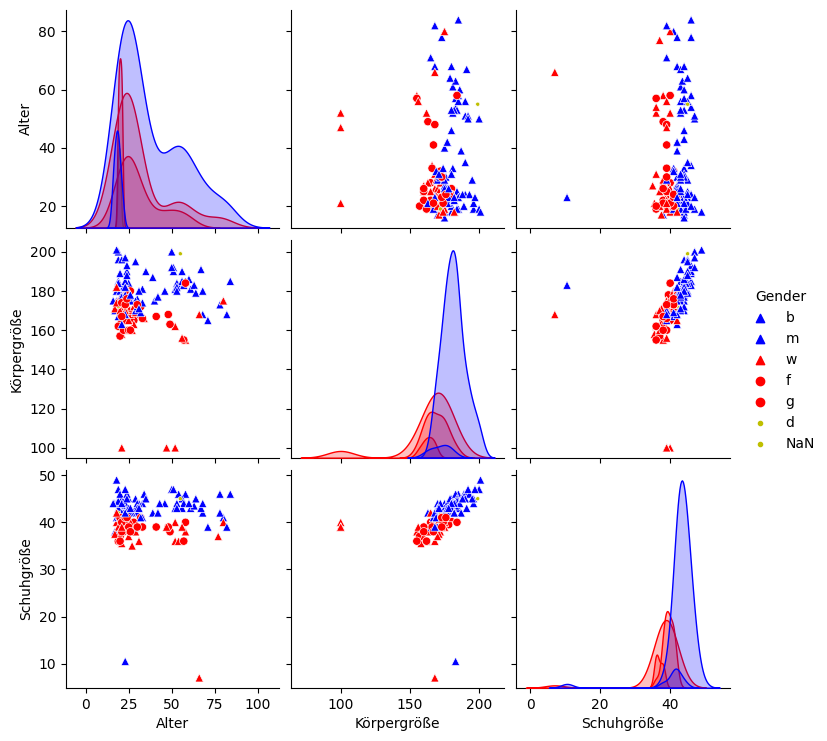

In [28]:
f="Erwachsen"
display(Markdown(f"**{f}**"))
sns.pairplot(database[f], hue=hue, markers=markers[hue], palette=palette[hue])

**Frauen**

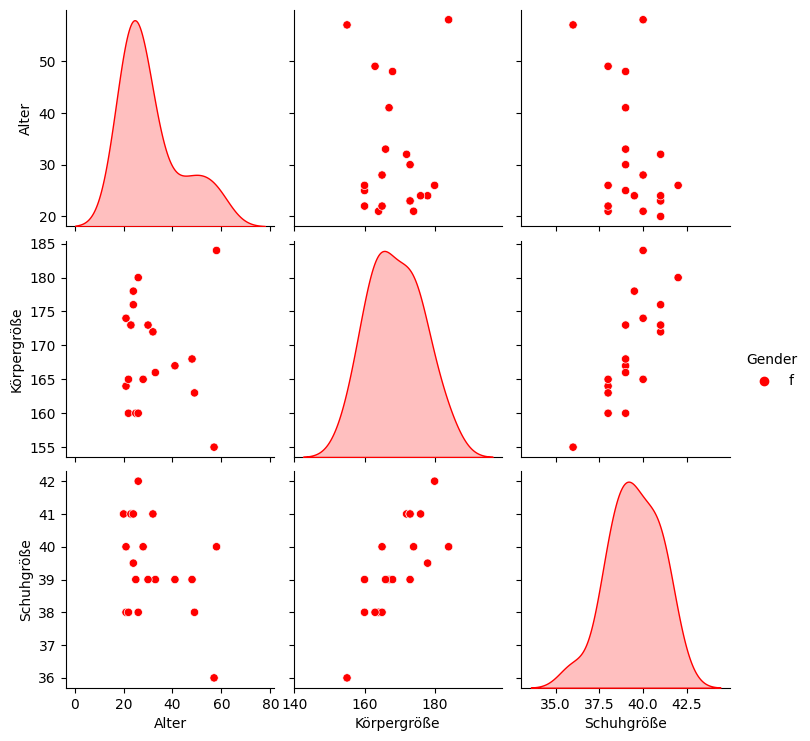

In [29]:
f = "Frauen"
display(Markdown(f"**{f}**"))
sns.pairplot(database[f], hue=hue, #markers=markers[hue], 
             palette=palette[hue])

In [30]:
# oder mehr fancy?
# https://seaborn.pydata.org/tutorial/distributions.html#plotting-many-distributions
#g = sns.PairGrid(X, hue = "Gender")
#g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
#g.map_diag(sns.histplot, kde=True)

Da könnte man hinwollen: Heranwachsende Männer (blau), erwachsene Frauen (rot) etc.:

<AxesSubplot: xlabel='Körpergröße', ylabel='Schuhgröße'>

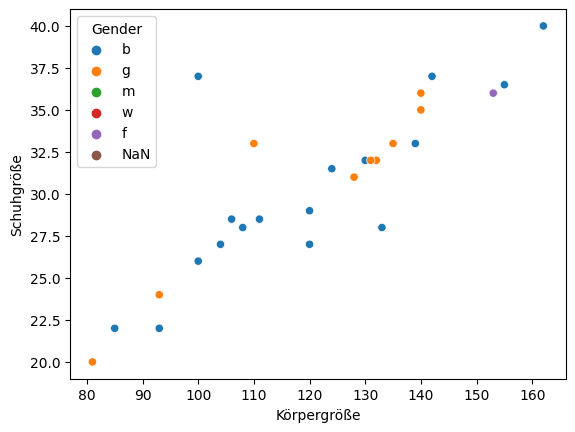

In [31]:
sns.scatterplot(x="Körpergröße", y="Schuhgröße", data=database["Heranwachsend"], color="c", hue=hue)
#sns.regplot(x="Körpergröße", y="Schuhgröße", data=database["Erwachsen"], color="c")